## Введение (1)

Учебный проект состоит из нескольких разделов (блокнотов), в которых последовательно обрабатываются данные, предоставленные организаторами соревнования Catch Me If You Can ("Alice") на платформе Kaggle. В проект входят следующие разделы:
* 1 - Введение, подготовка датасетов
* 2 - Исследование данных
* 3 - Обучение моделей
* 4 - Дополнительная глава

При изучении данных материалов важно помнить, что это мой первый опыт как программирования, так и анализа данных :) Буду благодарен каждому совету и указанию на ошибки!

<span style="color:red">Цель</span> учебного проекта заключается в получении навыков обработки и визуализации данных, в изучении основ машинного обучения, а также в знакомстве с площадкой Kaggle.

<span style="color:red">Задача</span>, поставленная передо мной и другими участниками соревнования - задача бинарной классификации сессий пользователей. Класс "1" - сессия Alice, класс "0" - все остальные.

### О данных

In [2]:
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy.sparse as sp
import pickle

PATH_TO_TRAIN = os.path.join('initial_data', 'train_sessions')
PATH_TO_TEST = os.path.join('initial_data', 'test_sessions')
PATH_TO_DICT = os.path.join('initial_data', 'site_dict')
PATH_TO_DATASET = os.path.join('intermediate_data', 'test_train')
PATH_TO_TRAIN_RAW = os.path.join('initial_data', 'user_logs')

Список исходных данных:
* Сырые данные в train.zip (распаковано в папку user_logs)
Сырые данные представляют из себя набор (1558 файлов, по одному на пользователя) csv-файлов. Каждый файл содержит таблицу из двух столбцов с информацией о последовательности посещённых пользователем сайтов. Например, так выглядят первые три строки файла user_logs/user0002.csv:
```
timestamp,site
2013-11-29 08:14:18,fpdownload2.macromedia.com
2013-11-29 08:14:26,hotmail.fr
...
```

* Подготовленный организаторами соревнования на Kaggle тренировочный набор сессий (сессия - последовательность из 10 сайтов, ограниченная по времени в 30 минут) в train_sessions/train_sessions.csv:

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_TRAIN, 'train_sessions.csv'), 
            index_col='session_id', parse_dates=['time' + str(j) for j in range(1,11)])
train_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253557,3474,2013-11-25 10:26:54,3474.0,2013-11-25 10:26:58,141.0,2013-11-25 10:27:03,2428.0,2013-11-25 10:27:04,106.0,2013-11-25 10:27:13,...,2013-11-25 10:27:16,2428.0,2013-11-25 10:27:28,2428.0,2013-11-25 10:27:40,2428.0,2013-11-25 10:27:52,148.0,2013-11-25 10:27:53,0
253558,12727,2013-03-12 16:01:15,12727.0,2013-03-12 16:01:16,2215.0,2013-03-12 16:01:16,38.0,2013-03-12 16:01:17,2215.0,2013-03-12 16:01:17,...,2013-03-12 16:01:17,25444.0,2013-03-12 16:01:18,2215.0,2013-03-12 16:01:18,23.0,2013-03-12 16:01:18,21.0,2013-03-12 16:01:18,0
253559,2661,2013-09-12 14:05:03,15004.0,2013-09-12 14:05:10,5562.0,2013-09-12 14:05:10,5562.0,2013-09-12 14:06:29,5562.0,2013-09-12 14:06:30,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  date

* Подготовленный организаторами тестовый набор сессий в test_sessions/test_sessions.csv:

In [8]:
test_df = pd.read_csv(os.path.join(PATH_TO_TEST, 'test_sessions.csv'), 
                      index_col='session_id', parse_dates=['time' + str(j) for j in range(1,11)])
test_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82793,812,2014-10-02 18:20:09,1039.0,2014-10-02 18:20:09,676.0,2014-10-02 18:20:09,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
82794,300,2014-05-26 14:16:40,302.0,2014-05-26 14:16:41,302.0,2014-05-26 14:16:44,300.0,2014-05-26 14:16:44,300.0,2014-05-26 14:17:19,1222.0,2014-05-26 14:17:19,302.0,2014-05-26 14:17:19,1218.0,2014-05-26 14:17:19,1221.0,2014-05-26 14:17:19,1216.0,2014-05-26 14:17:19
82795,29,2014-05-02 11:21:56,33.0,2014-05-02 11:21:56,35.0,2014-05-02 11:21:56,22.0,2014-05-02 11:22:03,37.0,2014-05-02 11:22:03,6779.0,2014-05-02 11:22:03,30.0,2014-05-02 11:22:03,21.0,2014-05-02 11:22:04,23.0,2014-05-02 11:22:04,6780.0,2014-05-02 11:22:04


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   site1   82797 non-null  int64         
 1   time1   82797 non-null  datetime64[ns]
 2   site2   81308 non-null  float64       
 3   time2   81308 non-null  datetime64[ns]
 4   site3   80075 non-null  float64       
 5   time3   80075 non-null  datetime64[ns]
 6   site4   79182 non-null  float64       
 7   time4   79182 non-null  datetime64[ns]
 8   site5   78341 non-null  float64       
 9   time5   78341 non-null  datetime64[ns]
 10  site6   77566 non-null  float64       
 11  time6   77566 non-null  datetime64[ns]
 12  site7   76840 non-null  float64       
 13  time7   76840 non-null  datetime64[ns]
 14  site8   76151 non-null  float64       
 15  time8   76151 non-null  datetime64[ns]
 16  site9   75484 non-null  float64       
 17  time9   75484 non-null  datetime64[ns]
 18  site10

## Подготовка датасетов

В данном блокноте содержатся функции, позволяющие подготовить тренировочный и тестовый наборы данных по образу сформированного организаторами соревнования на Kaggle для дальнейшей визуализации, генерации признаков и тренировки моделей. Это упражнение проделано для формирования навыков предобработки данных.

### Подготовка тренировочного набора данных

В данном разделе главная функция, подготавливающая набор данных - prepare_train_set_with_fe. На вход она принимает путь до файлов с информацией о пользователях (path_to_csv_files), путь до словаря с сайтами (path_to_site_dict), а также длину сессии session_length и ширину окна window_size. 

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, path_to_site_dict, 
                            session_length=10, window_size=10):
    ''' Подготавливает набор данных. Сырые данных хранятся в path_to_csv_files. 
    Возвращает DataFrame с сессиями и с несколькими извлеченными признаками
    Внимание! В текущем виде функция плохо работает с другим значением window_size'''
    
    with open(os.path.join(path_to_site_dict, 'site_dict.pkl'), 'rb') as file:
        site_dict = pickle.load(file)

    data = []
    
    list_of_files = glob(os.path.join(path_to_csv_files, '*'))         
    for path_to_user in tqdm(list_of_files):
        if 'Alice' in path_to_user:
            target = 1
        else:
            target = 0
            
        sites_array = pd.read_csv(path_to_user)['site'].map(site_dict).values.tolist()
        timestamps = pd.read_csv(path_to_user, parse_dates=['timestamp'])['timestamp']
        time_diffs, ind_reset_generator = timestamps_handling(timestamps)
        
        try:
            ind_reset = next(ind_reset_generator)
        except StopIteration:
            continue_iter = False
        continue_iter = True
        n = len(sites_array)
        ind = 0

        while True:
            if continue_iter and (ind_reset in range(ind, ind+session_length)):
                '''Если в сессии есть перерыв'''
                sites = sites_array[ind:ind_reset+1]
                times = time_diffs[ind:ind_reset]
                zeros_sites = [0 for _ in range(session_length-len(sites))]
                zeros_times = [0 for _ in range(session_length-len(times) - 1)]
                session = sites + zeros_sites + times + zeros_times
                
                features = add_features_to_train(timestamps, times, sites, ind)
                data.append(session + features + [target])

                ind = ind_reset + 1
                try:
                    ind_reset = next(ind_reset_generator)
                except StopIteration:
                    continue_iter = False
                    
            else:
                '''Если в сессии нет перерыва'''
                if ind + session_length > n-1:
                    '''Если сессия - последняя сессия пользователя'''
                    sites = sites_array[ind:n]
                    times = time_diffs[ind:n-1]
                    zeros_sites = [0 for _ in range(session_length-len(sites))]
                    zeros_times = [0 for _ in range(session_length-len(times) - 1)]
                    session = sites + zeros_sites + times + zeros_times
                    
                    features = add_features_to_train(timestamps, times, sites, ind)
                    data.append(session + features + [target])
                    
                    ind += window_size
                else:
                    '''Обычная сессия'''
                    sites = sites_array[ind:ind+session_length]
                    times = time_diffs[ind:ind+session_length-1]
                    session = sites + times

                    features = add_features_to_train(timestamps, times, sites, ind)
                    data.append(session + features + [target])
                    
                    ind += window_size

            if ind >= n:
                break
                
    feature_names=([f'site{i}' for i in range(1, session_length + 1)] +
                   [f'time_diff{i}' for i in range(1, session_length)] +
                   ['session_timespan', '#unique_sites', 'start_hour', 
                    'day_of_week', 'day', 'month', 'year',
                    'time', 'time_of_day'] +
                   ['target'])
    data_df = pd.DataFrame(data, columns=feature_names)

    return data_df

In [5]:
def timestamps_handling(timestamps):
    ''' Принимает на вход timestamps (pd.Series). Возвращает список с time_diff и
    генератор индексов перерывов (time_diffs >= 1800) '''
    
    time_diffs = (timestamps[1:].reset_index(drop=True)-
                  timestamps[:-1].reset_index(drop=True)).values
    
    time_diffs = np.array(time_diffs/1e9, dtype='int') # --> astype(int)

    return time_diffs.tolist(), (i for i in np.where(time_diffs >= 1800)[0])

In [6]:
def add_features_to_train(timestamps, times, sites, ind):
    ''' Добавляет основные фичи к тренировочному набору '''
    
    session_timespan = sum(times)
    num_unique_sites = len(set(sites)-{0})
    start_hour = timestamps[ind].hour
    day_of_week = timestamps[ind].weekday()
    start_day = timestamps[ind].day
    start_month = timestamps[ind].month
    start_year = timestamps[ind].year
    start_time = timestamps[ind].time()
    if timestamps[ind].hour >= 6: time_of_day = 'morning'
    if timestamps[ind].hour >= 12: time_of_day = 'afternoon'
    if timestamps[ind].hour >= 18: time_of_day = 'evening'
    
    return [session_timespan, num_unique_sites, start_hour, 
            day_of_week, start_day, start_month, start_year,
            start_time, time_of_day]

In [7]:
%%time
train_s10_w10_m30 = prepare_train_set_with_fe(PATH_TO_TRAIN_RAW, PATH_TO_DICT,
                                    session_length=10, window_size=10)


Wall time: 2min 30s


In [8]:
train_s10_w10_m30

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,session_timespan,#unique_sites,start_hour,day_of_week,day,month,year,time,time_of_day,target
0,270,270,270,21,21,7832,21,7832,30,7832,...,437,4,16,1,12,2,2013,16:25:10,afternoon,1
1,29,7832,37,7832,7832,29,7832,29,7832,7832,...,26,3,16,1,12,2,2013,16:32:27,afternoon,1
2,29,7832,7832,29,37,7832,29,7832,29,270,...,53,4,16,1,12,2,2013,16:32:53,afternoon,1
3,167,167,1515,167,37,1514,855,1515,855,1514,...,3,5,16,1,12,2,2013,16:33:50,afternoon,1
4,1516,1515,1514,1518,1521,1523,1519,1524,1517,855,...,0,10,16,1,12,2,2013,16:33:55,afternoon,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252205,3,3,8,3,3,4,4819,8,4819,6,...,15,5,16,0,17,3,2014,16:58:12,afternoon,0
252206,4819,8,41592,14,6,4819,10,14,7,4819,...,2,7,16,0,17,3,2014,16:58:28,afternoon,0
252207,4819,14,11,12,7,3,18,41592,14,4819,...,59,8,16,0,17,3,2014,16:58:31,afternoon,0
252208,11,66,63,8,29,30,162,131,162,29,...,18,8,16,0,17,3,2014,16:59:51,afternoon,0


In [9]:
with open(os.path.join(PATH_TO_DATASET, 'train_s10_w10_m30.pkl'), 'wb') as file:
    pickle.dump(train_s10_w10_m30, file)

Сформированный из сырых данных тренировочный набор данных получен достаточно быстро (~2 минуты) вследствие хорошей оптимизации используемой функции, однако в дальнейшем будет использоваться другой набор данных. Набор данных, на котором будут тренироваться модели, формируется в заключении данного раздела при помощи куда менее эффективной функции.

### Подготовка тестового набора данных

In [10]:
test_df = pd.read_csv(os.path.join(PATH_TO_TEST, 'test_sessions.csv'), 
                      index_col='session_id', parse_dates=['time' + str(j) for j in range(1,11)])

In [11]:
test_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82793,812,2014-10-02 18:20:09,1039.0,2014-10-02 18:20:09,676.0,2014-10-02 18:20:09,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
82794,300,2014-05-26 14:16:40,302.0,2014-05-26 14:16:41,302.0,2014-05-26 14:16:44,300.0,2014-05-26 14:16:44,300.0,2014-05-26 14:17:19,1222.0,2014-05-26 14:17:19,302.0,2014-05-26 14:17:19,1218.0,2014-05-26 14:17:19,1221.0,2014-05-26 14:17:19,1216.0,2014-05-26 14:17:19
82795,29,2014-05-02 11:21:56,33.0,2014-05-02 11:21:56,35.0,2014-05-02 11:21:56,22.0,2014-05-02 11:22:03,37.0,2014-05-02 11:22:03,6779.0,2014-05-02 11:22:03,30.0,2014-05-02 11:22:03,21.0,2014-05-02 11:22:04,23.0,2014-05-02 11:22:04,6780.0,2014-05-02 11:22:04


In [12]:
def feature_extracting_from_test(test_df, train=False):
    ''' Преобразует тестовый набор данных в вид, аналогичный тренировочному набору '''
    
    data_df = test_df.fillna(0)
    
    sites = ['site' + str(j) for j in range(1,11)]
    times = ['time_diff' + str(j) for j in range(1,10)]
    base_features = ['session_timespan', '#unique_sites', 
                     'start_hour', 'day_of_week', 'day',
                     'month', 'year', 'time', 'time_of_day']
    
    if train is True:
        base_features.append('target')
    
    new_df = pd.DataFrame(columns=sites + times + base_features,
                          index=range(1, data_df.shape[0] + 1))

    for column in ['site' + str(j) for j in range(1,11)]:
        new_df[column] = data_df[column]

    for j in range(1, 10):
        new_df['time_diff' + str(j)] = (test_df['time' + str(j+1)] - 
                                        test_df['time' + str(j)]).apply(lambda x: x.total_seconds())
    
    new_df['session_timespan'] = new_df.loc[:, 'time_diff1':'time_diff9'].sum(axis=1)

    for i in tqdm(range(1, data_df.shape[0])):
        sites_row = data_df[sites].iloc[i].values
        num_unique_in_session = np.unique(sites_row[sites_row != 0]).shape[0]
        new_df['#unique_sites'][i] = num_unique_in_session

    new_df['start_hour'] = test_df['time1'].apply(lambda x: x.hour)
    new_df['day_of_week'] = test_df['time1'].apply(lambda x: x.weekday())
    new_df['day'] = test_df['time1'].apply(lambda x: x.day)
    new_df['month'] = test_df['time1'].apply(lambda x: x.month)
    new_df['year'] = test_df['time1'].apply(lambda x: x.year)
    new_df['time'] = test_df['time1'].apply(lambda x: x.time())

    def time_of_day(x):
        time_of_day = 'night'
        if x.hour >= 6: time_of_day = 'morning'
        if x.hour >= 12: time_of_day = 'afternoon'
        if x.hour >= 18: time_of_day = 'evening'
        return time_of_day

    new_df['time_of_day'] = data_df['time1'].apply(time_of_day)
    
    if train is True:
        new_df['target'] = data_df['target']

    return new_df

In [13]:
%%time
test_df_final = feature_extracting_from_test(test_df)


Wall time: 5min 5s


In [14]:
test_df_final = test_df_final.fillna(0)

In [15]:
test_df_final

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,day,month,year,time,time_of_day
1,29,35.0,22.0,321.0,23.0,2211.0,6730.0,21.0,44582.0,15336.0,...,0.0,7.0,1,11,5,4,10,2014,11:19:53,morning
2,782,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,...,23.0,85.0,2,11,3,3,7,2014,11:00:28,morning
3,55,55.0,55.0,55.0,55.0,55.0,55.0,55.0,1445.0,1445.0,...,3.0,84.0,7,15,4,5,12,2014,15:55:12,afternoon
4,1023,1022.0,50.0,222.0,202.0,3374.0,50.0,48.0,48.0,3374.0,...,0.0,4.0,8,10,1,4,11,2014,10:03:19,morning
5,301,301.0,301.0,66.0,67.0,69.0,70.0,68.0,71.0,167.0,...,4.0,13.0,8,15,4,16,5,2014,15:05:31,afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82793,812,1039.0,676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6,18,3,2,10,2014,18:20:09,evening
82794,300,302.0,302.0,300.0,300.0,1222.0,302.0,1218.0,1221.0,1216.0,...,0.0,39.0,10,14,0,26,5,2014,14:16:40,afternoon
82795,29,33.0,35.0,22.0,37.0,6779.0,30.0,21.0,23.0,6780.0,...,0.0,8.0,7,11,4,2,5,2014,11:21:56,morning
82796,5828,23.0,21.0,804.0,21.0,3350.0,23.0,894.0,21.0,961.0,...,0.0,13.0,2,10,5,3,5,2014,10:05:25,morning


In [16]:
with open(os.path.join(PATH_TO_DATASET, 'test_s10_w10_m30_final.pkl'), 'wb') as file:
    pickle.dump(test_df_final, file)

Замечание! Модели, натренированные в разделе "Тренировка моделей" на полученном в этом разделе вручную тренировочном наборе, выдают меньший score на публичном тестовом наборе данных, чем при использовании сформированного организаторами тестового набора данных. Здесь будет применена функция feature_extracting_from_test с параметром train=True к сформированному организаторами набору данных train_sessions.csv. К сожалению, данная функция неоптимизирована и работает существенно дольше той, что собирает датасет из сырых данных.

In [17]:
train_df = pd.read_csv(os.path.join(PATH_TO_TRAIN, 'train_sessions.csv'), 
            index_col='session_id', parse_dates=['time' + str(j) for j in range(1,11)])

In [18]:
train_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253557,3474,2013-11-25 10:26:54,3474.0,2013-11-25 10:26:58,141.0,2013-11-25 10:27:03,2428.0,2013-11-25 10:27:04,106.0,2013-11-25 10:27:13,...,2013-11-25 10:27:16,2428.0,2013-11-25 10:27:28,2428.0,2013-11-25 10:27:40,2428.0,2013-11-25 10:27:52,148.0,2013-11-25 10:27:53,0
253558,12727,2013-03-12 16:01:15,12727.0,2013-03-12 16:01:16,2215.0,2013-03-12 16:01:16,38.0,2013-03-12 16:01:17,2215.0,2013-03-12 16:01:17,...,2013-03-12 16:01:17,25444.0,2013-03-12 16:01:18,2215.0,2013-03-12 16:01:18,23.0,2013-03-12 16:01:18,21.0,2013-03-12 16:01:18,0
253559,2661,2013-09-12 14:05:03,15004.0,2013-09-12 14:05:10,5562.0,2013-09-12 14:05:10,5562.0,2013-09-12 14:06:29,5562.0,2013-09-12 14:06:30,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0


In [19]:
%%time
train_df_final = feature_extracting_from_test(train_df, train=True)


Wall time: 39min


In [20]:
train_df_final = train_df_final.fillna(0)

In [21]:
with open(os.path.join(PATH_TO_DATASET, 'train_s10_w10_m30_final.pkl'), 'wb') as file:
    pickle.dump(train_df_final, file)

В результате выполнения кода из данного блокнота будут сформированы несколько файлов. В дальнейшем будут использоваться следующие:

* test_train/train_s10_w10_m30_final.pkl
* test_train/test_s10_w10_m30_final.pkl

## Исследование данных (2)

Результатом предыдущего блокнота стали два набора данных с некоторым количеством извлечённых признаков. В данном блокноте эти признаки исследуются и строятся новые.

In [24]:
import os
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import re
from matplotlib import pyplot as plt

PATH_TO_DATASET = os.path.join('intermediate_data', 'test_train')
PATH_TO_DICT = os.path.join('initial_data', 'site_dict')

In [25]:
with open(os.path.join(PATH_TO_DATASET, 'train_s10_w10_m30_final.pkl'), 'rb') as f:
    train_df = pickle.load(f)

train_df = train_df.sort_values(by=['year', 'month', 'day', 'time'])
y_train = train_df['target'].astype('int').values

Взглянем на подготовленный DataFrame.

In [26]:
train_df

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,session_timespan,#unique_sites,start_hour,day_of_week,day,month,year,time,time_of_day,target
21669,56,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8,8,5,12,1,2013,08:05:57,morning,0
54843,56,55.0,56.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1786.0,4,8,5,12,1,2013,08:37:23,morning,0
77292,946,946.0,951.0,946.0,946.0,945.0,948.0,784.0,949.0,946.0,...,4.0,7,8,5,12,1,2013,08:50:13,morning,0
114021,945,948.0,949.0,948.0,945.0,946.0,947.0,945.0,946.0,946.0,...,3.0,4,8,5,12,1,2013,08:50:17,morning,0
146670,947,950.0,948.0,947.0,950.0,952.0,946.0,951.0,946.0,947.0,...,2.0,5,8,5,12,1,2013,08:50:20,morning,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,50,50.0,48.0,49.0,48.0,52.0,52.0,49.0,303.0,304.0,...,12.0,6,23,2,30,4,2014,23:33:48,evening,0
164438,4207,753.0,753.0,52.0,50.0,4207.0,3346.0,3359.0,3346.0,38.0,...,178.0,5,23,2,30,4,2014,23:34:15,evening,0
12221,52,3346.0,784.0,784.0,3346.0,979.0,3324.0,7330.0,3594.0,3329.0,...,28.0,5,23,2,30,4,2014,23:38:08,evening,0
156968,3328,3324.0,3599.0,3413.0,753.0,3328.0,3599.0,3359.0,3359.0,3346.0,...,77.0,8,23,2,30,4,2014,23:38:36,evening,0


### Временные признаки

1. Время начала сессии.

Первый временной признак, который может оказаться интересным - время начала сессии. Если Alice придерживается определённого расписания, это поможет классификации.

In [27]:
session_start_hour = train_df['start_hour'].values

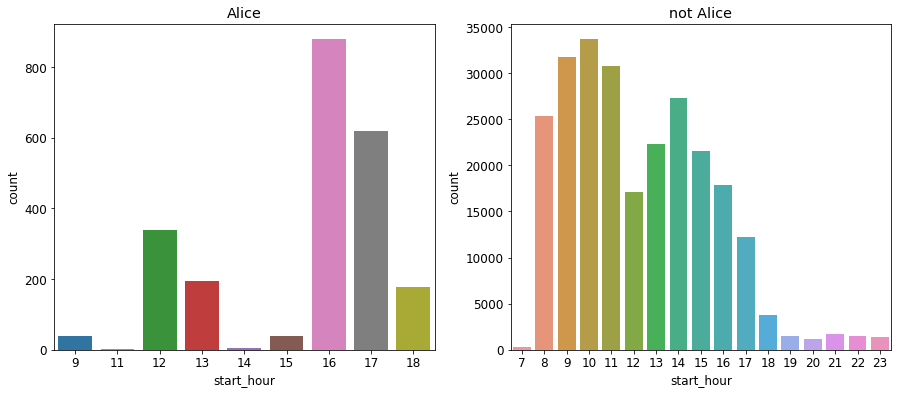

In [28]:
plt.subplots(1, 2, figsize = (15, 6)) 

plt.subplot(1, 2, 1)
ax = sns.countplot(session_start_hour[y_train == 1])
ax.set(title='Alice',
       xlabel='start_hour')
          
plt.subplot(1, 2, 2)
ax = sns.countplot(session_start_hour[y_train == 0])
ax.set(title='not Alice',
       xlabel='start_hour');


Судя по всему, расписание Alice и правда, серьёзно отличается от расписания остальных пользователей. В дальнейшем это наблюдение ляжет в основу для создания индикаторов времени суток.

2. День недели

Второй временной признак, который может оказаться интересным - день недели, в который данная сессия наблюдалась. 

In [29]:
session_day_of_week = train_df['day_of_week'].values

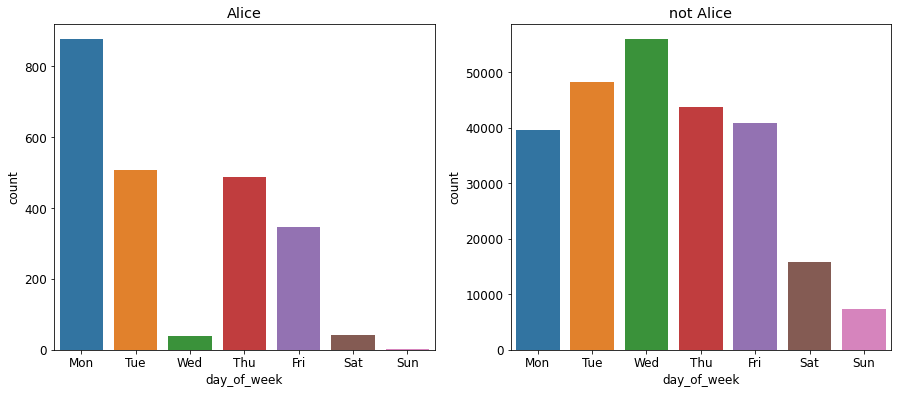

In [30]:
plt.subplots(1, 2, figsize = (15, 6)) 

plt.subplot(1, 2, 1)
ax = sns.countplot(session_day_of_week[y_train == 1])
ax.set(xlabel='day_of_week', 
       title='Alice', 
       xticklabels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
          
plt.subplot(1, 2, 2)
ax = sns.countplot(session_day_of_week[y_train == 0])
ax.set(xlabel='day_of_week', 
       title='not Alice', 
       xticklabels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']);

И снова наблюдаются некоторые особенности в поведении Alice.

3. Продолжительность сессии

Третий временной признак, который может оказаться интересным - продолжительность сессии.

In [31]:
session_timespan = train_df['session_timespan'].values

Посмотрим на некоторые характеристики продолжительности сессии в наборах данных.

In [32]:
print(
    '>>> ТРЕНИРОВОЧНЫЙ НАБОР ДАННЫХ\n'
    f'Максимальная продолжительность сессии: {round(session_timespan[y_train == 0].max())}\n' 
    f'Минимальная продолжительность сессии: {round(session_timespan[y_train == 0].min())}\n'
    f'Средняя продолжительность сессии: {round(session_timespan[y_train == 0].mean())}\n'
    f'25% - квантиль продолжительности сессии: {round(np.quantile(session_timespan[y_train == 0], 0.25))}\n'
    f'50% - квантиль продолжительности сессии: {round(np.quantile(session_timespan[y_train == 0], 0.50))}\n'
    f'75% - квантиль продолжительности сессии: {round(np.quantile(session_timespan[y_train == 0], 0.75))}\n'
    f'95% - квантиль продолжительности сессии: {round(np.quantile(session_timespan[y_train == 0], 0.95))}\n'
    f'99% - квантиль продолжительности сессии: {round(np.quantile(session_timespan[y_train == 0], 0.99))}\n')

>>> ТРЕНИРОВОЧНЫЙ НАБОР ДАННЫХ
Максимальная продолжительность сессии: 1800
Минимальная продолжительность сессии: 0
Средняя продолжительность сессии: 139
25% - квантиль продолжительности сессии: 7
50% - квантиль продолжительности сессии: 28
75% - квантиль продолжительности сессии: 114
95% - квантиль продолжительности сессии: 786
99% - квантиль продолжительности сессии: 1610



In [33]:
print(
    '>>> НАБОР ДАННЫХ ДЛЯ ALICE\n'
    f'Максимальная продолжительность сессии: {round(session_timespan[y_train == 1].max())}\n' 
    f'Минимальная продолжительность сессии: {round(session_timespan[y_train == 1].min())}\n'
    f'Средняя продолжительность сессии: {round(session_timespan[y_train == 1].mean())}\n'
    f'25% - квантиль продолжительности сессии: {round(np.quantile(session_timespan[y_train == 1], 0.25))}\n'
    f'50% - квантиль продолжительности сессии: {round(np.quantile(session_timespan[y_train == 1], 0.50))}\n'
    f'75% - квантиль продолжительности сессии: {round(np.quantile(session_timespan[y_train == 1], 0.75))}\n'
    f'95% - квантиль продолжительности сессии: {round(np.quantile(session_timespan[y_train == 1], 0.95))}\n'
    f'99% - квантиль продолжительности сессии: {round(np.quantile(session_timespan[y_train == 1], 0.99))}\n')

>>> НАБОР ДАННЫХ ДЛЯ ALICE
Максимальная продолжительность сессии: 1763
Минимальная продолжительность сессии: 0
Средняя продолжительность сессии: 52
25% - квантиль продолжительности сессии: 4
50% - квантиль продолжительности сессии: 11
75% - квантиль продолжительности сессии: 38
95% - квантиль продолжительности сессии: 203
99% - квантиль продолжительности сессии: 827



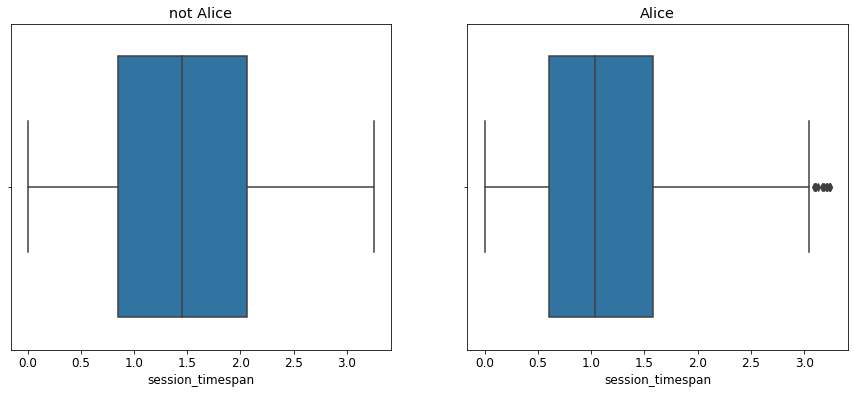

In [34]:
import matplotlib
font = {'size': 12}
matplotlib.rc('font', **font)

plt.subplots(1, 2, figsize = (15, 6))

plt.subplot(1, 2, 1)
ax = sns.boxplot(np.log10(session_timespan[y_train == 0]))
ax.set(xlabel='session_timespan', 
       title='not Alice');

plt.subplot(1, 2, 2)
ax = sns.boxplot(np.log10(session_timespan[y_train == 1]))
ax.set(xlabel='session_timespan', 
       title='Alice');

Средняя продолжительность сессии Alice несколько меньше. Это будет использовано при дальнейшем построении признаков.

Хотелось бы использовать не только признак "Продолжительность сессии" как таковой, но также попытаться выделить характерные для Alice продолжительности. Для этого проведём более тонкий анализ.

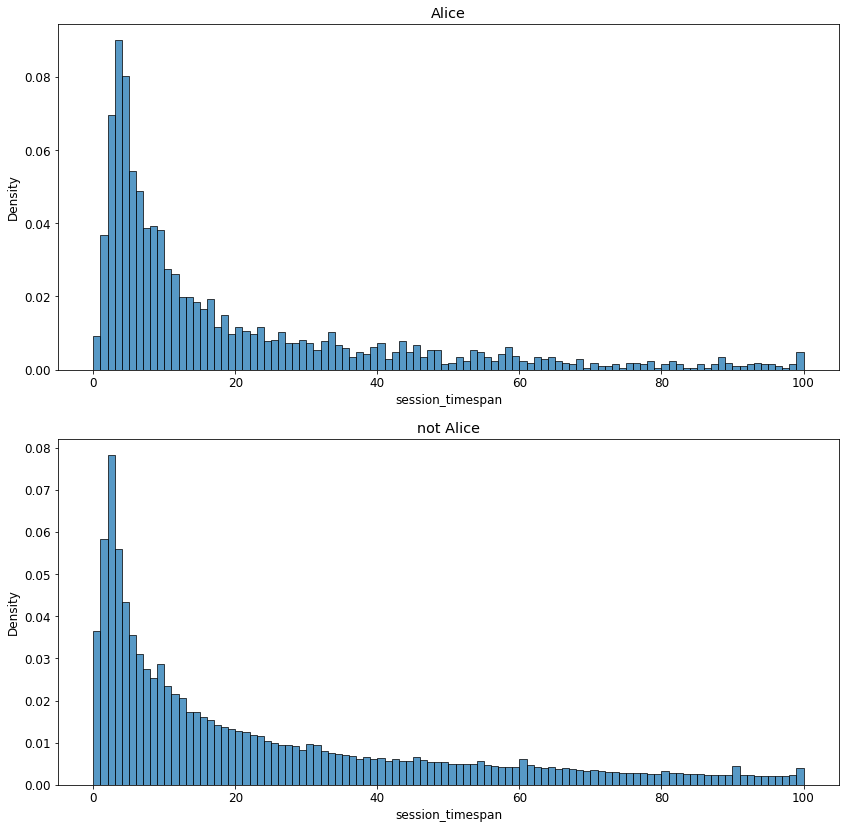

In [35]:
plt.subplots(ncols=1, nrows=2, figsize = (14, 14)) 

plt.subplot(2, 1, 1)
ax = sns.histplot(session_timespan[y_train == 1], 
                  binwidth=1,
                  binrange=(0, 100),
                  stat="density"
                 )
ax.set(xlabel='session_timespan', 
       title='Alice')
 
plt.subplot(2, 1, 2)
ax = sns.histplot(session_timespan[y_train == 0], 
                  binwidth=1,
                  binrange=(0, 100),
                  stat="density")
ax.set(xlabel='session_timespan', 
       title='not Alice');

Вблизи нулевых значений продолжительности сессии, гистограммы заметно отличаются, вероятно это то, что нам надо. Можно построить хитрую тепловую карту, в каждой ячейке которой будет содержаться разница между процентным содержанием сессии данной продолжительности у Alice и у всех, кроме Alice. 

Например, сессия с продолжительностью 0 секунд в наборе сессий у Alice встречается в 0.83% всех сессий, а у всех, кроме Alice в 2.61%, значит, разница для сессий продолжительностью 0 секунд равна -1.78%. Это может, например, означать, что Alice меньше других склонна открывать много вкладок за раз.

При необходимости, в определённую ниже функцию per_difference_heatmap можно передавать количество секунд для группировки.

Минимальная разница: -1.8 %
Максимальная разница: 4.1 %

Положительные значения означают, что сессия Alice чаще других имеет данную продолжительнось


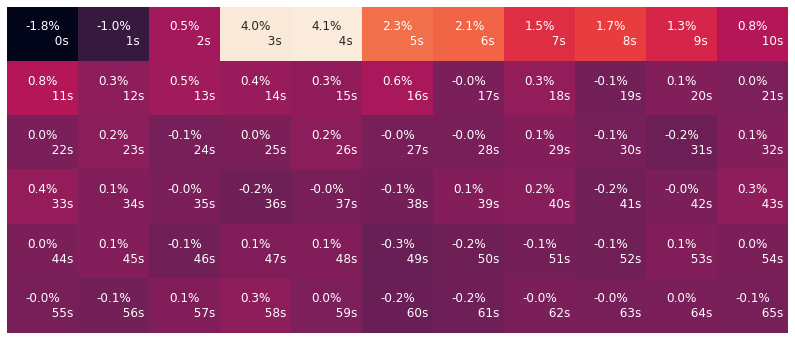

In [36]:
def per_difference_heatmap(seconds_to_group=1):
    ''' Строит heatmap для разницы продолжительности сессии (Alice - not Alice)
    Положительные значения означают, что сессия Alice чаще других имеет данную
    продолжительнось. При необходимости можно изменять временное окно (seconds_to_group)'''
    start_second = 0
    stop_second = 100 * seconds_to_group
    
    def session_timespan_info(df, bins):
        times = df['session_timespan'].values
        result = []
        for i in range(len(bins)-1):
            result.append(times[(times >= bins[i]) & (times  < bins[i+1])].shape[0])
        return np.array(result)
    
    bins = [i for i in range(start_second, stop_second, seconds_to_group)]
    times_alice = session_timespan_info(train_df[train_df['target'] == 1], bins)
    times_not_alice = session_timespan_info(train_df[train_df['target'] == 0], bins)

    alice_percentage = times_alice/train_df[train_df['target'] == 1].shape[0] * 100
    not_alice_percentage = times_not_alice/train_df[train_df['target'] == 0].shape[0] * 100
    difference = alice_percentage - not_alice_percentage
    
    print(f'Минимальная разница: {round(difference.min(), 1)} %')
    print(f'Максимальная разница: {round(difference.max(), 1)} %')

    print(f'\n\033[1mПоложительные значения означают, что сессия Alice чаще других имеет данную продолжительнось\033[0m')
    plt.subplots(1, 1, figsize = (14, 6))
    labels = np.array([f'{round(diff, 1)}%\n          {sec*seconds_to_group}s' 
                       for sec, diff in enumerate(difference[:66])]).reshape(-1, 11)
    sns.heatmap(data=difference[:66].reshape(-1, 11), 
                annot=labels, xticklabels=False, 
                yticklabels=False, cbar=False, fmt='')
    
    
per_difference_heatmap(seconds_to_group=1)

На основе данной таблицы в дальнейшем будет построен признак, учитывающий особенности продолжительности сессии Alice.

### Признаки, связанные с набором сайтов в сессии

Следующая группа признаков, которая может нас заинтересовать связана с набором сайтов в сессии. Подавляющее большинство признаков этой группы будет порождено вдальнейшем в виде матрицы частот с помощью CountVectorizer (или TfidfVectorizer), здесь же будут исследованы остальные признаки, которые могут быть извлечены из наборов сайтов в сессии.

1. Количество уникальных сайтов в сессии

Возможно, отличить Alice от остальных, количество различных сайтов, которые она использует в пределах одной сессии.

In [37]:
num_unique_sites = train_df['#unique_sites'].values

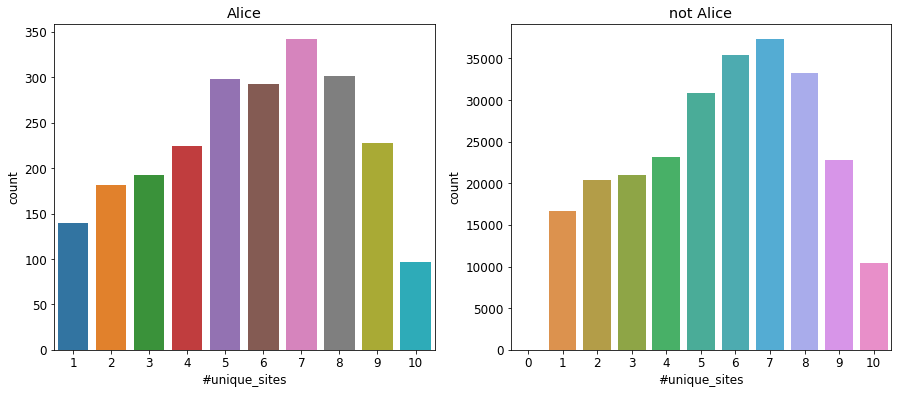

In [38]:
plt.subplots(1, 2, figsize = (15, 6)) 

plt.subplot(1, 2, 1)
ax = sns.countplot(num_unique_sites[y_train == 1])
ax.set(title='Alice',
       xlabel='#unique_sites')
          
plt.subplot(1, 2, 2)
ax = sns.countplot(num_unique_sites[y_train == 0])
ax.set(title='not Alice',
       xlabel='#unique_sites');

Диаграмма для Alice имеет слабовыраженные особенности, возможно, в дальнейшем стоит попробовать их использовать для построения признаков.

2. Сайты, встречающиеся чаще в сессии Alice, чем в сессиях других пользователей и наоборот

В дальнейшем хотелось бы создать несколько признаков-идикаторов или счетчиков для определённых сайтов в сессии, наличие или количество которых могло бы дополнительно повысить качество классификации.

In [39]:
def attendance_list(df, target):
    '''Вспомогательная функция. Возвращает топ сайтов (id сайта, количество посещений)'''
    
    ind, cnt = np.unique(df[df['target'] == target]
                         [['site%s' % i for i in range(1, 11)]].values.ravel(), return_counts=True)
    ind_cnt = np.hstack((ind.reshape(-1,1), cnt.reshape(-1,1))).tolist()
    ind_cnt.sort(key=lambda x: x[1], reverse=True)
    return ind_cnt

In [40]:
def out_of_popular_sites(alice_first, not_alice_first, top_alice):
    ''' Возвращает множество сайтов, входящих в топ-Alice, но не входящие в топ-not_Alice (top_alice=True).
        Либо возвращает множество сайтов, входящих в топ-not_Alice, но не входящие в топ-Alice (top_alice=False).'''
    
    alice_top = attendance_list(train_df, target=1)[:alice_first]
    all_top = attendance_list(train_df, target=0)[:not_alice_first]

    set_alice_top = set([site[0] for site in alice_top])
    set_not_alice_top = set([site[0] for site in all_top])
    if top_alice is True:
        return set_alice_top - set_not_alice_top
    if top_alice is False:
        return set_not_alice_top - set_alice_top

In [41]:
for_check = [(100, 3900), (60, 1000), (60, 2200), (20, 150), (10, 45), (10, 40), (5, 20)]

for alice_first, not_alice_first in for_check:
    print(f'Среди топ-{alice_first} сайтов Alice, сайты, которые не входят в топ-{not_alice_first}: '
          f'{out_of_popular_sites(alice_first, not_alice_first, top_alice=True)}')

Среди топ-100 сайтов Alice, сайты, которые не входят в топ-3900: {27307.0, 27172.0, 27189.0, 25383.0}
Среди топ-60 сайтов Alice, сайты, которые не входят в топ-1000: {2080.0, 12619.0, 27307.0, 263.0}
Среди топ-60 сайтов Alice, сайты, которые не входят в топ-2200: {27307.0}
Среди топ-20 сайтов Alice, сайты, которые не входят в топ-150: {3000.0}
Среди топ-10 сайтов Alice, сайты, которые не входят в топ-45: {81.0, 82.0}
Среди топ-10 сайтов Alice, сайты, которые не входят в топ-40: {81.0, 82.0, 879.0}
Среди топ-5 сайтов Alice, сайты, которые не входят в топ-20: {77.0}


In [42]:
for_check = [(100, 30), (100, 20), (100, 10), (100, 5)]

for alice_first, not_alice_first in for_check:
    print(f'Среди топ-{not_alice_first} сайтов, сайты, которые не входят в топ-{alice_first} сайтов Alice: '
          f'{out_of_popular_sites(alice_first, not_alice_first, top_alice=False)}')


Среди топ-30 сайтов, сайты, которые не входят в топ-100 сайтов Alice: {778.0, 780.0, 812.0, 782.0, 786.0, 55.0, 56.0, 570.0}
Среди топ-20 сайтов, сайты, которые не входят в топ-100 сайтов Alice: {778.0, 780.0, 812.0, 782.0, 786.0, 55.0, 570.0}
Среди топ-10 сайтов, сайты, которые не входят в топ-100 сайтов Alice: {778.0, 780.0, 782.0}
Среди топ-5 сайтов, сайты, которые не входят в топ-100 сайтов Alice: {782.0}


Заметим, что имеется ряд сайтов, которые Alice посещает чаще, чем остальные люди в наборе данных. Также, имеются и такие сайты, которые Alice посещает реже, чем остальные люди. В дальнейшем будут сформированы два признака-индикатора вхождения одного из интересующих сайтов в сессию.

Посмотрим на сайты, обнаруженные таким образом

In [43]:
with open(os.path.join(PATH_TO_DICT, 'site_dict.pkl'), 'rb') as file:
    sites_dict = pickle.load(file)
reversed_dict = {v: k for k, v in sites_dict.items()}
reversed_dict[0] = '0'

In [44]:
sites_top_alice = {3000, 2080, 27307, 12619, 263, 25383, 81, 81, 879, 77}
sites_top_not_alice = {55, 56, 570, 778, 780, 782, 786, 812}

print('\033[1m Alice \033[0m\n')
for site in sites_top_alice:
    print(f'{site}: {reversed_dict[site]}')
    
print('\n\033[1m not Alice \033[0m\n')
for site in sites_top_not_alice:
    print(f'{site}: {reversed_dict[site]}')

 Alice 

2080: media-1.melty.fr
263: www.caf.fr
25383: www.cjn.justice.gouv.fr
27307: fr.glee.wikia.com
12619: youwatch.org
77: i1.ytimg.com
879: r1---sn-gxo5uxg-jqbe.googlevideo.com
81: r4---sn-gxo5uxg-jqbe.googlevideo.com
3000: vk.com

 not Alice 

778: www.ncbi.nlm.nih.gov
780: blast.ncbi.nlm.nih.gov
812: mail.google.com
782: annotathon.org
786: www.phylogeny.fr
55: safebrowsing-cache.google.com
56: safebrowsing.clients.google.com
570: plus.google.com


Среди найденных сайтов имеются такие, которые в результате дополнительной проверки оказались неинформативными (Alice посещала их всего в нескольких сессиях) и в дальнейшем эти сайты (263, 25383) не использовались при построении признаков.

Видим, что Alice довольно часто использует французские сайты, возможно получится выделить подходящий признак.

3. Встречается ли домен 'fr' в названии сайта

В предыдущем пункте было обнаружено, что в некоторых уникальных для Alice сайтах иногда встречается домен 'fr'. Следует сравнить частоту появления этого домена в сайтах Alice и в сайтах остальных пользователей.

In [45]:
def hist_for_counted_words(df, pattern, sites_dict, density=True):
    ''' Строит гистограммы для частот встреченных сайтов в сессии, 
        с подстрокой 'pattern' '''

    def search_and_sub(df, pattern):
        import copy
        new_df = copy.copy(df)

        sites = ['site%s' % i for i in range(1, 11)]
        for site in sites:
            new_df[site] = new_df[site].apply(lambda x: 1 if re.search(pattern, str(x)) else 0)
            
        return new_df
    
    print(f'Поиск: "{pattern}"')
    
    sites = ['site%s' % i for i in range(1, 11)]
    sites_df = df[sites].fillna(0).astype('int').applymap(lambda x: sites_dict[x])
    sites_df['target'] = df['target']
    
    sites_df = search_and_sub(sites_df, pattern)
    sites_df['count'] = sites_df[sites].values.sum(axis=1)
    
    plt.subplots(1, 2, figsize = (15, 6))
    
    plt.subplot(1, 2, 1)
    ax = sites_df[sites_df['target'] == 1]['count'].hist(range=(1, 11), density=density)
    ax.set(title='Alice',
           xlabel='number of occurrences')
    
    plt.subplot(1, 2, 2)
    ax = sites_df[sites_df['target'] == 0]['count'].hist(range=(1, 11), density=density)   
    ax.set(title='not Alice',
           xlabel='number of occurrences')

Поиск: ".fr"


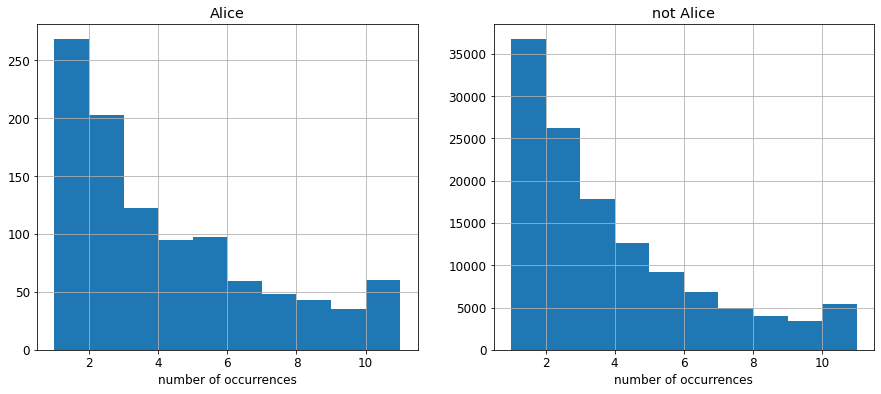

In [46]:
hist_for_counted_words(train_df, '.fr', reversed_dict, density=False)

Существенных отличий двух распределений не наблюдается, что скорее всего означает, что признак будет неинформативным. К слову, найти подстроку, по которой можно было бы построить хороший признак, так и не представилось возможным.

В следующем разделе найденные закономерности будут применены для добавления новых признаков к тренировочному и тестовому наборам данных.

## Обучение моделей (3)

В этом блокноте используются файлы, полученные при помощи предыдущих блокнотов (тренировочный и тестовый наборы данных). Наборы векторизуются, к полученным разреженным матрицам добавляются новые признаки, а затем на полученных данных обучается **логистическая регресиия** и применяется для классификации тестовых сессий.

**Целевая метрика** – ROC AUC.

**Содержание**
1. Загрузка предподготовленных данных
2. Применение CountVectorizer и TfidfVectorizer
3. Функции для добавления фичей
4. Применение преобразованных наборов данных для классификации
5. Применение новых фичей для классификации
6. Заключение

### Загрузка предподготовленных данных

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook
import pickle

import numpy as np
import pandas as pd

import scipy.sparse as sp

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import (SGDClassifier, LogisticRegression, 
                                  LogisticRegressionCV)
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

PATH_TO_DATASET = os.path.join('intermediate_data', 'test_train')
PATH_TO_DICT = os.path.join('initial_data', 'site_dict')

def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    ''' Записывает файл для посылки в Kaggle '''

    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [2]:
with open(os.path.join(PATH_TO_DATASET, 'train_s10_w10_m30_final.pkl'), 'rb') as f:
    train_df = pickle.load(f)

with open(os.path.join(PATH_TO_DATASET, 'test_s10_w10_m30_final.pkl'), 'rb') as f:
    test_df = pickle.load(f)

train_df = train_df.sort_values(by=['year', 'month', 'day', 'time'])
y_train = train_df['target'].astype('int').values

### Применение CountVectorizer и TfidfVectorizer

Далее будет проведено сравнение результатов моделей, обученных на двух наборах данных полученных разными методами:
* при помощи CountVectorizer
* при помощи TfidfVectorizer

CountVectorizer реализует простой метод bag-of-words, а TfidfVectorizer учитывает частоты вхождений сайта в сессии. Значение, полученное с использованием TfidfVectorizer рассчитывается по следующей формуле:

$$TF-IDF = TF \times IDF = \frac{число\:вхождений\:слова\:в\:документ}{общее\:количество\:слов\:в\:документе} \times \log\left( \frac{общее\:количество\:документов}{число\:документов,\:включающих\:слово}\right)$$


In [48]:
sites = ['site%s' % i for i in range(1, 11)]

train_df[sites].fillna(0).astype('int').to_csv(os.path.join('intermediate_data', 'train_sessions_text_cnt.txt'), 
                                               sep=' ', 
                       index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv(os.path.join('intermediate_data', 'test_sessions_text_cnt.txt'), 
                                              sep=' ', 
                       index=None, header=None)

with open(os.path.join(PATH_TO_DICT, 'site_dict.pkl'), 'rb') as file:
    sites_dict = pickle.load(file)
reversed_dict = {v: k for k, v in sites_dict.items()}
reversed_dict[0] = '0'

train_df[sites].fillna(0).astype('int').applymap(
    lambda x: reversed_dict[x]).to_csv(os.path.join('intermediate_data', 'train_sessions_text_tfidf.txt'), sep=' ', 
    index=None, header=None)
test_df[sites].fillna(0).astype('int').applymap(
    lambda x: reversed_dict[x]).to_csv(os.path.join('intermediate_data', 'test_sessions_text_tfidf.txt'), sep=' ', 
    index=None, header=None)

In [49]:
%%time
cnt_vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=50000)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 5), max_features=100000, tokenizer=lambda s: s.split())
with open(os.path.join('intermediate_data', 'train_sessions_text_cnt.txt')) as inp_train_file:
    X_train = cnt_vectorizer.fit_transform(inp_train_file)
with open(os.path.join('intermediate_data', 'train_sessions_text_tfidf.txt')) as inp_train_file:
    X_train_tfidf = tfidf_vectorizer.fit_transform(inp_train_file)
with open(os.path.join('intermediate_data', 'test_sessions_text_cnt.txt')) as inp_test_file:
    X_test = cnt_vectorizer.transform(inp_test_file)
with open(os.path.join('intermediate_data', 'test_sessions_text_tfidf.txt')) as inp_test_file:
    X_test_tfidf = tfidf_vectorizer.transform(inp_test_file)

Wall time: 35.6 s


In [50]:
cnt_vectorizer.get_feature_names()[:10]

['10',
 '10 1086',
 '10 11',
 '10 11 11',
 '10 11 12',
 '10 11 14',
 '10 11 15',
 '10 11241',
 '10 1199',
 '10 12']

In [51]:
tfidf_vectorizer.get_feature_names()[:10]

['0',
 '0 0',
 '0 0 0',
 '0 0 0 0',
 '0 0 0 0 0',
 '0.academia-assets.com',
 '0.docs.google.com',
 '0.docs.google.com 0',
 '0.docs.google.com 0 0',
 '0.docs.google.com 0 0 0']

### Функции для добавления фичей

In [8]:
def add_time_features(df, X_sparse):
    ''' Добавляет индикаторы (4 признака) утра, дня, вечера и ночи '''

    hour = df['start_hour']
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    X = sp.hstack([X_sparse, morning.values.reshape(-1, 1), 
                day.values.reshape(-1, 1), evening.values.reshape(-1, 1), 
                night.values.reshape(-1, 1)])
    return X

In [9]:
def add_session_timespan(df, X_sparse):
    ''' Добавляет продолжительность сессии в секундах (1 признак) '''

    session_timespan = df['session_timespan']
    X = sp.hstack([X_sparse, session_timespan.values.reshape(-1, 1)])
    return X
    

In [10]:
def feature_short_session(df, X_sparse, time_min=0, time_max=3):
    ''' Добавляет индикаторы короткой сессии (от 0 до 2 секунд) 
    (1 признак)'''

    def short_session(x): 
        if ((x >= time_min) and (x < time_max)):
            return 1
        return 0

    times = df['session_timespan']
    X = sp.hstack([X_sparse, times.apply(short_session).values.reshape(-1, 1)])
    return X
    

def feature_middle_session(df, X_sparse, time_min=3, time_max=9):
    ''' Добавляет индикаторы средней сессии (от 3 до 6 секунд) 
    (1 признак)'''

    def middle_session(x): 
        if ((x >= time_min) and (x < time_max)):
            return 1
        return 0

    times = df['session_timespan']
    X = sp.hstack([X_sparse, times.apply(middle_session).values.reshape(-1, 1)])
    return X

In [11]:
def add_top_sites(df, X_sparse, list_of_sites={3000, 2080, 27307}):
    ''' Добавляет индикаторы (1 признак) нескольких сайтов, которые Alice 
    использует замето чаще, чем остальные люди '''
    
    sites = df[['site%s' % i for i in range(1, 11)]].values
    result = [0]*sites.shape[0]

    for i, session in enumerate(sites):
        for site in session:
            if site in list_of_sites:
                result[i] += 1
    
    X = sp.hstack([X_sparse, np.array(result).reshape(-1, 1)])
    return X

In [12]:
def add_reverse_top_sites(df, X_sparse, list_of_sites={55, 56, 570, 
                                                       778, 780, 782, 
                                                       786, 812}):
    ''' Добавляет индикаторы (1 признак) нескольких сайтов, которые Alice 
    использует замето реже, чем остальные люди '''

    sites = df[['site%s' % i for i in range(1, 11)]].values
    result = [0]*sites.shape[0]

    for i, session in enumerate(sites):
        for site in session:
            if site in list_of_sites:
                result[i] += 1
    
    X = sp.hstack([X_sparse, np.array(result).reshape(-1, 1)])
    return X

In [13]:
''' Оказалось, что признак плохой и приводит к переобучению '''

def add_start_hour(df, X_sparse):
    ''' Добавляет час начала сессии (1 признак) '''

    start_hour = df['start_hour']
    X = sp.hstack([X_sparse, start_hour.values.reshape(-1, 1)])
    return X
    

In [14]:
def add_day_of_week(df, X_sparse):
    ''' Добавляет день начала сессии (1 признак) '''

    day_of_week = df['day_of_week']
    X = sp.hstack([X_sparse, day_of_week.values.reshape(-1, 1)])
    return X

Далее закомментированы определения функций, добавляющих плохие признаки.

In [15]:
'''
def add_num_of_unique(df, X_sparse):
    # Добавляет количество уникальных сайтов в сессии (1 признак)

    num_of_unique = df['#unique_sites']
    X = sp.hstack([X_sparse, num_of_unique.values.reshape(-1, 1)])
    return X
'''

"\ndef add_num_of_unique(df, X_sparse):\n    # Добавляет количество уникальных сайтов в сессии (1 признак)\n\n    num_of_unique = df['#unique_sites']\n    X = sp.hstack([X_sparse, num_of_unique.values.reshape(-1, 1)])\n    return X\n"

In [16]:
'''
from sklearn.preprocessing import StandardScaler

def add_session_timespan_scaled(df, X_sparse):
    session_timespan = df['session_timespan_scaled']
    X = sp.hstack([X_sparse, session_timespan.values.reshape(-1, 1)])
    return X
    
scaler_sess_timespan = StandardScaler(with_std=False, with_mean=False)
train_df['session_timespan_scaled'] = scaler_sess_timespan.fit_transform(train_df['session_timespan'].values.reshape(-1, 1))
test_df['session_timespan_scaled'] = scaler_sess_timespan.transform(test_df['session_timespan'].values.reshape(-1, 1))
'''

"\nfrom sklearn.preprocessing import StandardScaler\n\ndef add_session_timespan_scaled(df, X_sparse):\n    session_timespan = df['session_timespan_scaled']\n    X = sp.hstack([X_sparse, session_timespan.values.reshape(-1, 1)])\n    return X\n    \nscaler_sess_timespan = StandardScaler(with_std=False, with_mean=False)\ntrain_df['session_timespan_scaled'] = scaler_sess_timespan.fit_transform(train_df['session_timespan'].values.reshape(-1, 1))\ntest_df['session_timespan_scaled'] = scaler_sess_timespan.transform(test_df['session_timespan'].values.reshape(-1, 1))\n"

### Применение преобразованных наборов данных для классификации

В данном разделе были обучены LogisticRegressionCV на двух тренировочных наборах данных:
- К тренировочным и тестовым наборам, преобразованным при помощи CountVectorizer и TfidfVectorizer добавлены индикаторы утра, дня, вечера и ночи.
- Определены показатели метрики roc-auc.
- Обученные LogisticRegressionCV с найденным коэффициентом регуляризации прменены для классификации сессий в соответствующих тестовых наборах данных.
- Отправлены посылки в соревновании на Kaggle.
- Сделаны выводы.


In [17]:
time_split = TimeSeriesSplit(n_splits=10) # для валидации
y_train = train_df['target'].astype('int').values

In [18]:
X_train_cnt_1f = add_time_features(train_df.fillna(0), X_train)
X_test_cnt_1f = add_time_features(test_df.fillna(0), X_test)

X_train_tfidf_1f = add_time_features(train_df.fillna(0), X_train_tfidf)
X_test_tfidf_1f = add_time_features(test_df.fillna(0), X_test_tfidf)

In [19]:
%%time
logit_c_values = np.linspace(0.1, 5, 10)

logit_grid_searcher_cnt = LogisticRegressionCV(Cs=logit_c_values, 
                                            solver='liblinear', 
                                            random_state=17,
                                            cv=time_split,
                                            n_jobs=-1, scoring='roc_auc',
                                            verbose=3,
                                            max_iter=2000)
logit_grid_searcher_cnt.fit(X_train_cnt_1f, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   38.2s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.5min remaining:   39.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.5min finished


[LibLinear]Wall time: 2min 39s


LogisticRegressionCV(Cs=array([0.1       , 0.64444444, 1.18888889, 1.73333333, 2.27777778,
       2.82222222, 3.36666667, 3.91111111, 4.45555556, 5.        ]),
                     cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
                     max_iter=2000, n_jobs=-1, random_state=17,
                     scoring='roc_auc', solver='liblinear', verbose=3)

In [20]:
logit_mean_cv_scores_cnt = logit_grid_searcher_cnt.scores_[1].mean(axis=0)
print(logit_mean_cv_scores_cnt.max(), 
      logit_grid_searcher_cnt.Cs_[logit_mean_cv_scores_cnt.argmax()])

0.9166806003300598 0.6444444444444445


In [21]:
logit_test_pred_cnt= logit_grid_searcher_cnt.predict_proba(X_test_cnt_1f)[:, 1]
write_to_submission_file(logit_test_pred_cnt, 'submit_cnt.csv') # 0.93980

In [22]:
%%time
logit_c_values = np.linspace(0.1, 5, 10)

logit_grid_searcher_tfidf = LogisticRegressionCV(Cs=logit_c_values, 
                                            solver='liblinear', 
                                            random_state=17,
                                            cv=time_split,
                                            n_jobs=-1, scoring='roc_auc',
                                            verbose=3,
                                            max_iter=2000)
logit_grid_searcher_tfidf.fit(X_train_tfidf_1f, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   16.6s remaining:   38.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   29.2s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.2s finished


[LibLinear]Wall time: 39.6 s


LogisticRegressionCV(Cs=array([0.1       , 0.64444444, 1.18888889, 1.73333333, 2.27777778,
       2.82222222, 3.36666667, 3.91111111, 4.45555556, 5.        ]),
                     cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
                     max_iter=2000, n_jobs=-1, random_state=17,
                     scoring='roc_auc', solver='liblinear', verbose=3)

In [23]:
logit_mean_cv_scores_tfidf = logit_grid_searcher_tfidf.scores_[1].mean(axis=0)
print(logit_mean_cv_scores_tfidf.max(), 
      logit_grid_searcher_tfidf.Cs_[logit_mean_cv_scores_tfidf.argmax()])

0.9245491008379615 4.455555555555556


In [24]:
logit_test_pred_tfidf = logit_grid_searcher_tfidf.predict_proba(X_test_tfidf_1f)[:, 
1]
write_to_submission_file(logit_test_pred_tfidf, 'submit_tfidf.csv') # 0.94368

Поскольку более высокому roc-auc в leaderboard у TfidfVectorizer соответствует более высокое значение данной метрики и на валидации, то можно сделать вывод об удачном выборе метода валидации. В дальнейшем будут использоваться наборы данных, преобразованные при помощи TfidfVectorizer.

In [25]:
X_train_1f = X_train_tfidf_1f
X_test_1f = X_test_tfidf_1f

### Применение новых фичей для классификации

Каждый признак добавлялся по отдельности для наблюдения повышения качества на кросс-валидации.

In [26]:
X_train_2f = add_session_timespan(train_df, X_train_1f)
X_test_2f = add_session_timespan(test_df, X_test_1f)

In [27]:
X_train_3f = feature_short_session(train_df, X_train_2f)
X_test_3f = feature_short_session(test_df, X_test_2f) 

In [28]:
X_train_4f = add_top_sites(train_df, X_train_3f)
X_test_4f = add_top_sites(test_df, X_test_3f)

In [29]:
X_train_5f = add_reverse_top_sites(train_df, X_train_4f)
X_test_5f = add_reverse_top_sites(test_df, X_test_4f) 

In [30]:
X_train_6f = feature_middle_session(train_df, X_train_5f)
X_test_6f = feature_middle_session(test_df, X_test_5f)

In [44]:
logit_c_values = np.linspace(3, 5, 50)

logit_final = LogisticRegressionCV(Cs=logit_c_values, 
                                   solver='liblinear', 
                                   random_state=17,
                                   cv=time_split,
                                   n_jobs=-1, scoring='roc_auc',
                                   verbose=3,
                                   penalty='l2')
logit_final.fit(X_train_6f, y_train)

logit_mean_cv_scores = logit_final.scores_[1].mean(axis=0)
print(logit_mean_cv_scores.max(), logit_final.Cs_[logit_mean_cv_scores.argmax()])

# 0.9321137656775317 3.6530612244897958 # 0.95044

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  4.1min remaining:  9.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  6.8min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.4min finished


[LibLinear]0.9321137656775317 3.6530612244897958


In [45]:
logit_final = LogisticRegression(C=3.6530612244897958, 
                                 solver='liblinear', 
                                 random_state=17, 
                                 n_jobs=-1, 
                                 penalty='l2')
logit_final.fit(X_train_6f, y_train)

LogisticRegression(C=3.6530612244897958, n_jobs=-1, random_state=17,
                   solver='liblinear')

In [46]:
logit_final_cv_score = cross_val_score(logit_final, 
                                       X_train_6f, 
                                       y_train, 
                                       scoring='roc_auc', 
                                       cv=time_split).mean()
print('final cv score:', logit_final_cv_score)

final cv score: 0.9310553238208839


In [47]:
logit_test_pred_final = logit_final.predict_proba(X_test_6f)[:, 1]
write_to_submission_file(logit_test_pred_final, 'subm_logit_final.csv')

### Заключение

Score на публичной части тестовых данных: **0.95044**. Результат далёк от лучших позиций в рейтинге, однако целью проделанной работы являлось знакомство с площадкой Kaggle, получение навыков обработки и визуализации данных, а также изучение основ машинного обучения.

В качестве шагов для улучшения качества построенной модели в дальнейшем будут проделаны следующие шаги:
* применение других методов машинного обучения (бустинг над решающими деревьями, метод ближайших соседей);
* улучшения в схеме кросс-валидации (замечено, что не всегда рост roc-auc на кросс-валидации соответствует росту roc-auc на публичной части тестовых данных);
* проверка на переобученность модели при использовании отдельных признаков.

## Дополнительная глава (4)

В данном блокноте собраны функции, позволяющие обработать наборы данных о посещениях сайтов пользователями. Сырые данные для этой задачи представляют собой cvs-файлы с данными о веб-сёрфинге отдельного пользователя в следующем виде: 
```
timestamp,site
2013-11-15 11:40:34,google.com
...
```
Требуется объединить коллекцию таких файлов в одну большую таблицу. При этом в полученной таблице отдельные строки - это сессии - последовательности из нескольких сайтов. Решение должно поддерживать создание таблицы с разной длиной сессии, а также с различной шириной окна.

**Пример**: для длины сессии 10 и ширины окна 7 файл из 30 записей породит не 3 сессии (1-10, 11-20, 21-30), а 5 (1-10, 8-17, 15-24, 22-30, 29-30). При этом в предпоследней сессии будет один ноль, а в последней – 8 нолей.

<span style="color:red">Важное замечание!</span> Задача, поставленная в этом разделе не связана напрямую с решением предложенной организаторами соревнования на Kaggel. Задача решалась исключительно в факультативных целях и для того, чтобы осознать необходимость оптимизации кода.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd

import itertools
import re
import scipy.sparse as sp
import time

PATH_TO_DATA = os.path.join('initial_data', 'users')
PATH_TO_SITE_FREQ = os.path.join('initial_data', 'site_freq')

Посмотрим на файл с данными на примере пользователя user0128 из коллекции с 10 пользователями.

In [2]:
user31_data = pd.read_csv(os.path.join(PATH_TO_DATA, '10users/user0128.csv'))
user31_data.head()

,timestamp,site
0,2013-11-15 13:46:03,fpdownload2.macromedia.com
1,2013-11-15 13:46:13,mail.google.com
2,2013-11-15 13:46:13,www.gmail.com
3,2013-11-15 13:46:25,accounts.google.com
4,2013-11-15 13:46:28,accounts.youtube.com


Основная функция в этом разделе - это функция
```
prepare_sparse_train_set_window.
```
Она принимает на вход путь к коллекции csv-файлов с данными по каждому пользователю, путь к заранее подготовленному словарю сайтов, а также параметры session_length и window_size, отвечающие за длину сессии и размер окна соответственно.

Для удобства, отдельно определена функция
```
make_sparse_data,
```
которая помогает на основе таблицы с сессиями создаёт матрицу частот в разреженном формате.

In [3]:
def make_sparse_data(data):
    ''' Принимает на вход DataFrame с сессиями и 
    возвращает разреженную матрицу частот'''
    
    indptr = [0]
    indices = []
    sparse_data = []
    for row in tqdm(data):
        val, cnt = np.unique(row[row != 0], return_counts=True)
        indptr.append(indptr[-1] + len(val))
        for v, c in zip(val, cnt):
            indices.append(v - 1)
            sparse_data.append(c)
            
    return np.uint64(sparse_data),  np.uint64(indices), np.uint64(indptr)

In [4]:
def prepare_data_set_window(path_to_csv_files, site_freq_path, 
                            session_length=10, window_size=10):
    ''' Подготавливает набор данных. Сырые данных хранятся в path_to_csv_files. 
    Возвращает матрицу частот в разреженном формате, вектор с user_id и DataFrame
    с соответствующим набором сессий'''
    
    with open(site_freq_path, 'rb') as file:
        site_freq_dict = pickle.load(file)
 
    data = []
    
    list_of_files = glob(os.path.join(path_to_csv_files, '*'))         
    for path_to_user in list_of_files:
        user_id = int(re.sub(r'\b0+', '', path_to_user[-8:-4], 1)) # user0001 --> 1
        sites_array = pd.read_csv(path_to_user)['site'].map(lambda x: site_freq_dict[x][0]).values.tolist()
        n = len(sites_array)
        ind = 0
        while True:
            if ind + session_length > n-1:
                data.append(sites_array[ind:n] + [0 for _ in range(ind + session_length - n)] + [user_id])
            else:
                data.append(sites_array[ind:ind+session_length] + [user_id])
            ind += window_size
            if ind >= n:
                break
    
    feature_names=[f'site{i}' for i in range(1, session_length + 1)] + ['target']
    data_df = pd.DataFrame(data, columns=feature_names)
    target = np.array(data_df['target'].values, dtype='int16')
    
    '''Создание и заполнение разреженной матрицы частот'''
    X, y = data_df.iloc[:, :-1].values, data_df.iloc[:, -1].values
    sparse_data = sp.csr_matrix(make_sparse_data(X), dtype='int8')
     
    return sparse_data, target, data_df 

In [5]:
%%time
X_sparse_10users_s10_w7, y_10users_s10_w7, df = prepare_data_set_window(os.path.join(PATH_TO_DATA,'150users'), 
                                                    os.path.join(PATH_TO_SITE_FREQ,'site_freq_150users.pkl'),
                                                    session_length=10, window_size=7)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195712/195712 [00:06<00:00, 30078.11it/s]


Wall time: 9.7 s


Обработаем наборы данных для 10 и 150 пользователей и сохраним разреженные матрицы в формате 
```
X_sparse_{кол-во пользователей}users_s{длина сессии}_w{ширина окна}.pkl 
```
Также сохраним id пользователей в формате
```
y_{кол-во пользователей}users_s{длина сессии}_w{ширина окна}.pkl
```



In [6]:
%%time
for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length:
            X_sparse, y, _ = prepare_data_set_window(os.path.join(PATH_TO_DATA,'{}users'.format(num_users)),
                                                            os.path.join(PATH_TO_SITE_FREQ,'site_freq_{}users.pkl'.format(num_users)),
                                                            session_length=session_length, window_size=window_size)
            with open(os.path.join(PATH_TO_DATA, 
                                   'X_sparse_{}users_s{}_w{}.pkl'.format(num_users, 
                                                                         session_length, 
                                                                         window_size)), 'wb') as X_pkl:
                pickle.dump(X_sparse, X_pkl)
            with open(os.path.join(PATH_TO_DATA,
                                   'y_{}users_s{}_w{}.pkl'.format(num_users, 
                                                                  session_length, 
                                                                  window_size)), 'wb') as y_pkl:
                pickle.dump(y, y_pkl)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 273957/273957 [00:08<00:00, 32502.36it/s]


Wall time: 1min 39s


Теперь, когда подготовлены таблицы с сессиями в различных форматах (с различными session_length и window_size), можно попробовать натренировать модели (например, логистическую регрессию) на различных наборах данных. Тренировать модели на данных 150 пользователей долго, поэтому для примера, воспользуемся датасетами для 10 пользователей.

In [7]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

def logit_cv(logit_c_values, path_to_X_pickle, path_to_y_pickle):
    ''' Тренирует LogisticRegressionCV с параметром из logit_c_values 
    на данных из path_to_X_pickle и path_to_y_pickle'''
    
    with open(path_to_X_pickle, 'rb') as X_sparse_users_pkl:
        X_sparse_users = pickle.load(X_sparse_users_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)

    logit_c_values = np.linspace(0.5, 4, 5)

    logit_grid_searcher = LogisticRegressionCV(Cs=logit_c_values, 
                                               multi_class='multinomial', 
                                               random_state=17,
                                               cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=17),
                                               n_jobs=-1)
    logit_grid_searcher.fit(X_sparse_users, y)

    return logit_grid_searcher

logit_c_values = np.linspace(0.5, 6, 5)

In [8]:
all_logit_searchers = []

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pickle = os.path.join(PATH_TO_DATA,
                                     f'X_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pickle = os.path.join(PATH_TO_DATA, 
                                     f'y_10users_s{session_length}_w{window_size}.pkl')
        
        logit_grid_searcher = logit_cv(logit_c_values, path_to_X_pickle, path_to_y_pickle)
        
        all_logit_searchers.append(logit_grid_searcher)
        
        print(f'session_length = {session_length}, window_size = {window_size}')
        logit_mean_cv_scores = logit_grid_searcher.scores_[31].mean(axis=0)
        print('max cv score for user0031: ', logit_mean_cv_scores.max())
        print('best C: ', logit_grid_searcher.Cs_[logit_mean_cv_scores.argmax()])

session_length = 15, window_size = 10
max cv score for user0031:  0.8381338453879525
best C:  1.375
session_length = 10, window_size = 10
max cv score for user0031:  0.7763316976032999
best C:  1.375
session_length = 15, window_size = 7
max cv score for user0031:  0.8637924201474676
best C:  3.125
session_length = 10, window_size = 7
max cv score for user0031:  0.8123162268245263
best C:  1.375
session_length = 7, window_size = 7
max cv score for user0031:  0.7587494040411881
best C:  3.125
session_length = 15, window_size = 5
max cv score for user0031:  0.8841665915712135
best C:  3.125
session_length = 10, window_size = 5
max cv score for user0031:  0.8334162722580608
best C:  4.0
session_length = 7, window_size = 5
max cv score for user0031:  0.7878939587540709
best C:  3.125
session_length = 5, window_size = 5
max cv score for user0031:  0.7368590432312572
best C:  3.125


Наилучшее качество на кросс-валидации оказалось у датасета session_length = 15, window_size = 5. В дальнейшем можно проверить то же самое на более крупных датасетах, например на датасете 3000users. Но это выходит за рамки дополнительной главы, которая на этом заканчивается.

----------------------------

### Заключение

Score на публичной части тестовых данных: **0.95044**. Результат далёк от лучших позиций в рейтинге, однако целью проделанной работы являлось знакомство с площадкой Kaggle, получение навыков обработки и визуализации данных, а также изучение основ машинного обучения.

В качестве шагов для улучшения качества построенной модели в дальнейшем будут проделаны следующие шаги:
* применение других методов машинного обучения (бустинг над решающими деревьями, метод ближайших соседей);
* улучшения в схеме кросс-валидации (замечено, что не всегда рост roc-auc на кросс-валидации соответствует росту roc-auc на публичной части тестовых данных);
* проверка на переобученность модели при использовании отдельных признаков.